In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils.load_data import load_gt_data
from statsmodels.tsa.seasonal import seasonal_decompose

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
SEED = 42

In [95]:
gt_data = load_gt_data()

gt_data['date'] = pd.to_datetime(gt_data['date'])
gt_data = gt_data.sort_values(by='date')

In [96]:
gt_cols = [col for col in gt_data.columns if col not in ['date', 'country']]

gt_data_melted = gt_data.melt(id_vars=['date', 'country'], value_vars=gt_cols)

gt_data_melted

,date,country,variable,value
0,2004-01-01,Switzerland,Expense_average,0.0
1,2004-01-01,United States,Expense_average,39.0
2,2004-01-01,Germany,Expense_average,69.0
3,2004-01-01,Japan,Expense_average,74.0
4,2004-01-01,Canada,Expense_average,22.0
...,...,...,...,...
161205,2024-05-01,Germany,Employment_average,20.0
161206,2024-05-01,Switzerland,Employment_average,78.0
161207,2024-05-01,Korea,Employment_average,93.0
161208,2024-05-01,Canada,Employment_average,59.0


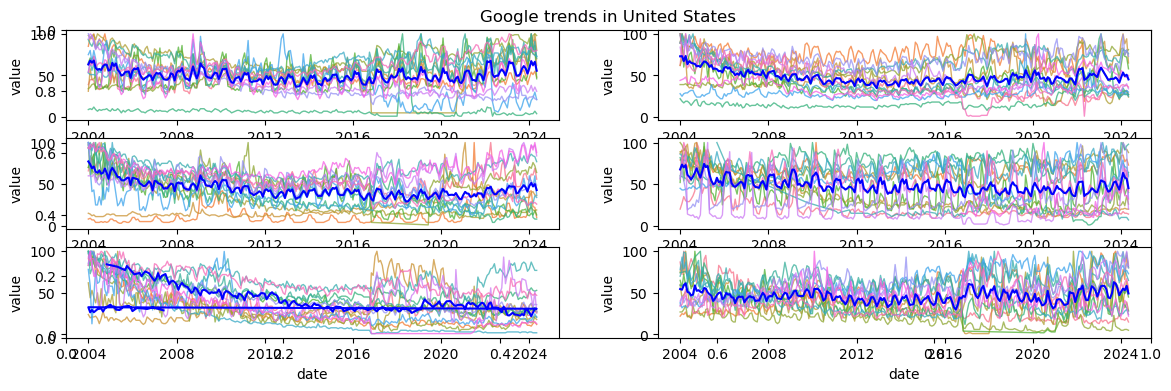

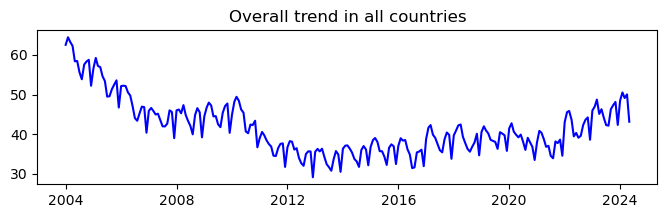

In [97]:
def plot_overall_trend(data, country, title=None, col=None, col_label=None, new_figs=True, plot_average=True):
    
    cols = [col for col in data.columns if col not in ['date', 'country']]

    data_melted = data.melt(id_vars=['date', 'country'], value_vars=cols)

    country_mask = data_melted['country'] == country
    zero_mask = data_melted['value'] != 0

    if col is not None:
        if new_figs:
            plt.figure(figsize=(8,4))

        mask = country_mask & zero_mask & (data_melted['variable'] == cols[-1])

        plt.title(f'Google trends in {country} for {col}')

        sns.lineplot(data_melted[mask], x='date', y='value', linewidth=1, label=col_label)
    else:
        if new_figs:
            plt.figure(figsize=(14,4))

        masks = {}
        for i in range(6):
            masks[i] = country_mask & zero_mask & data_melted['variable'].isin(cols[(i*15):((i+1)*15)])

        if title is not None:
            plt.title(title)
        else:
            plt.title(f'Google trends in {country}')

        for i in range(6):
            plt.subplot(int(f"32{i+1}"))
            sns.lineplot(data_melted[masks[i]], x='date', y='value', hue='variable', legend=None, linewidth=1, alpha=0.75)
            if plot_average:
                plt.plot(data_melted[masks[i]]['date'].unique(), data_melted[masks[i]].groupby('date')['value'].agg("mean"), color='b')

        plt.show()

        if plot_average:
            plt.figure(figsize=(8, 2))
            plt.title(f"Overall trend in all countries")
            plt.plot(data_melted[zero_mask]['date'].unique(), data_melted[zero_mask].groupby('date')['value'].agg("mean"), color='b')
            plt.show()

plot_overall_trend(gt_data, "United States")


## 1st approach (Léonard) : seasonal decompose average over columns

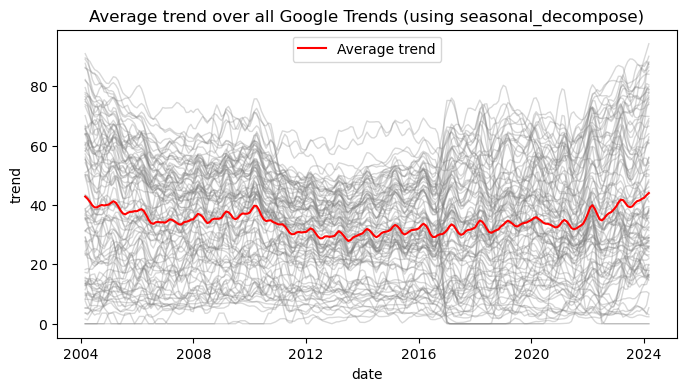

In [98]:
def get_average_trend(data, plot=False):
    data = data.copy()

    gt_cols = [col for col in data.columns if col not in ['date', 'country']]

    data = data.drop('country', axis=1).groupby('date').mean()
    
    trends, seasonals, residuals = {}, {}, {}
    for col in gt_cols:
        decompose_result = seasonal_decompose(data[col], model="additive", period=4)

        trends[col] = decompose_result.trend
        seasonals[col] = decompose_result.seasonal
        residuals[col] = decompose_result.resid

    mean_trend = np.mean([trends[col] for col in trends], axis=0)
    if plot:
        plt.figure(figsize=(8, 4))

        for col in trends:
            sns.lineplot(x=data.index, y=trends[col], color='gray', alpha=0.3, linewidth=1)

        sns.lineplot(x=data.index, y=mean_trend, color='red', label="Average trend")
        plt.title('Average trend over all Google Trends (using seasonal_decompose)')

    return mean_trend



mean_trend = get_average_trend(gt_data, plot=True)

## 2nd approach (OECD paper) : HP filter then PCA

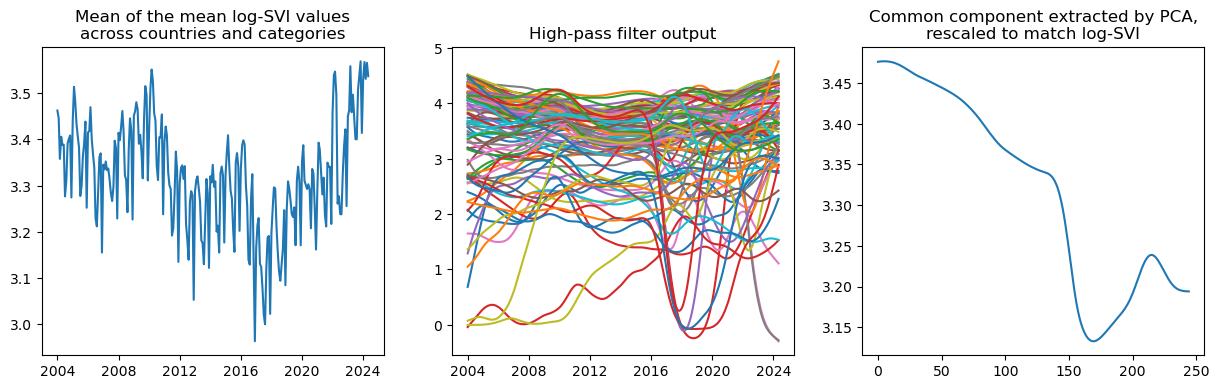

In [99]:
from sklearn.decomposition import PCA
from statsmodels.tsa.filters.hp_filter import hpfilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def remove_common_component(data, plot=False):
    data = data.copy()

    if plot:
        plt.figure(figsize=(15, 4))
    
    # Compute the log of the mean SVI values across countries
    means_over_countries = data.drop('country', axis=1).groupby('date').mean()
    log_svi = means_over_countries.apply(np.log1p)

    mean_over_time = log_svi.mean(axis=1)
    log_svi_average_mean, log_svi_average_std = mean_over_time.mean(), mean_over_time.std()

    if plot:
        plt.subplot(131)
        plt.plot(mean_over_time)
        plt.title('Mean of the mean log-SVI values\nacross countries and categories')

    # Apply HP filtering to extract long-term trend
    hp_output = log_svi.apply(lambda x: hpfilter(x, lamb=1600)[1])  # Long-term trend
    if plot:
        plt.subplot(132)
        plt.plot(hp_output)
        plt.title('High-pass filter output')

    # Normalize the long-term trends for PCA
    mean, std = hp_output.mean(axis=1).values, hp_output.std(axis=1).values
    hp_output = (hp_output - mean[:, None]) / std[:, None]

    # Apply PCA to extract the common component
    pca = PCA(n_components=1)
    common_component = pca.fit_transform(hp_output)

    # Rescale PCA component to the same scale as log-SVI
    common_component = (common_component - np.mean(common_component)) / np.std(common_component)
    common_component = common_component * log_svi_average_std + log_svi_average_mean  # Rescaled to match log-SVI TODO is it correct?

    if plot:
        plt.subplot(133)
        plt.plot(common_component)
        plt.title('Common component extracted by PCA,\nrescaled to match log-SVI')
        plt.show()

    # Subtract the common component from each series
    data[gt_cols] = np.log1p(data[gt_cols])
    for date_index, date in enumerate(data['date'].sort_values().unique()):
        date_mask = data['date'] == date
        data.loc[date_mask, gt_cols] -= common_component[date_index].item()


    # Return to original SVI scale
    data[gt_cols] = np.expm1(data[gt_cols])

    return data

detrended_gt_data = remove_common_component(gt_data, plot=True)

# IS THIS CORRECT ? :

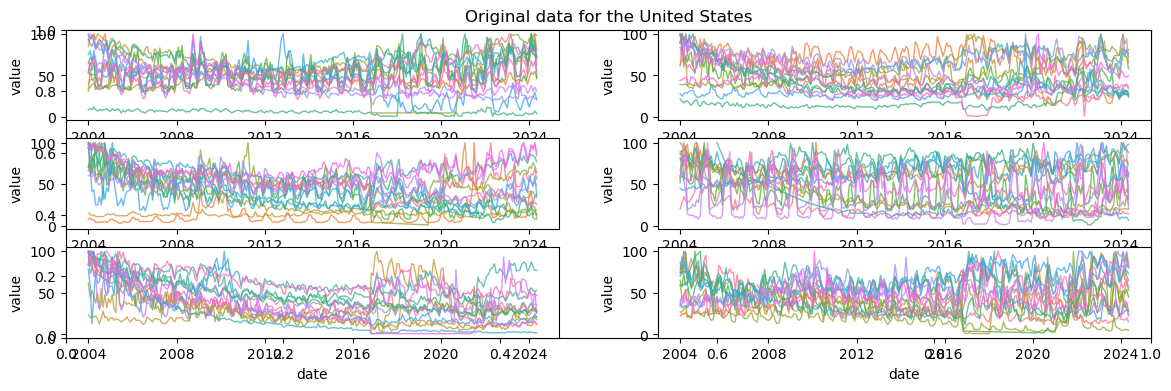

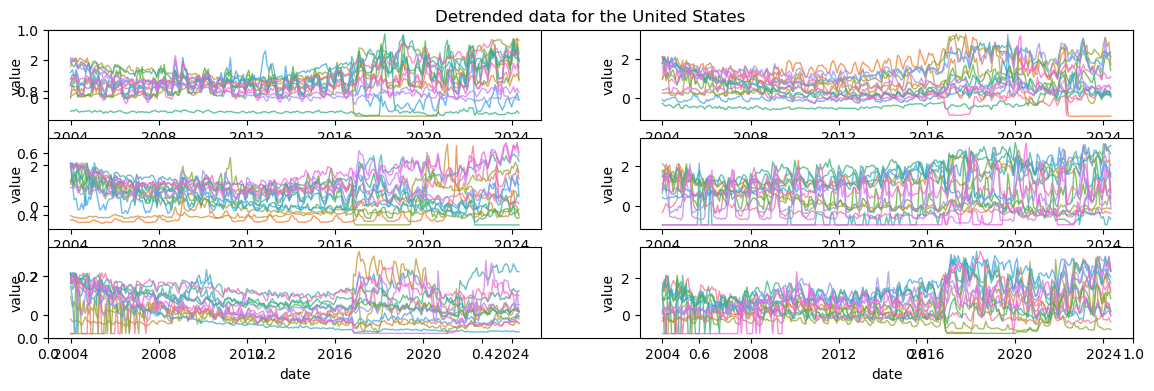

In [100]:
plot_overall_trend(gt_data, "United States", title="Original data for the United States", plot_average=False)
plot_overall_trend(detrended_gt_data, "United States", title="Detrended data for the United States", plot_average=False)